# Verification for Cutoffs
In this notebook we examine the historgram of # of blobs (or edges) extracted as a function of cutoff size. We also plot a few example simulation images with keypoints overlayed to illustrate the difference.

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from numba import prange
from skimage import feature as skif
from skimage.feature import blob_log
from sklearn.model_selection import ParameterGrid, KFold
from sklearn.tree import DecisionTreeRegressor
from IPython.display import clear_output
from itertools import product
%matplotlib inline

In [6]:
# Precharattana Model constants
CELL_H   = 0
CELL_A2  = 1
CELL_A0  = 2
CELL_A1  = 4
CELL_D   = 8

mycmap = {
    CELL_H: [255, 255, 255],
    CELL_A2: [0, 255, 0],
    CELL_A0: [128, 128, 0],
    CELL_A1: [0, 128, 0],
    CELL_D: [0, 0, 0], 
}

names = {
    CELL_H: 'Healthy',
    CELL_A2: 'Stage 1 Infected',
    CELL_A0: 'Latent Infected',
    CELL_A1: 'Stage 2 Infected', 
    CELL_D: 'Dead', 
}

In [ ]:
# Rana Model constants

## Loading data

In [20]:
from numba import types
from numba import njit
from numba.typed import Dict
int_array = types.int64[:]

In [36]:
@njit(parallel=True)
def proc(picture):
    healthy, dead, infected_A1, infected_A2 = 0, 0, 0, 0
    mycmap = Dict.empty(
        key_type=types.float64,
        value_type=int_array
    )
    data = np.zeros((600, 600, 3), dtype=np.uint8)
    mycmap[CELL_H] = np.array((255, 255, 255))
    mycmap[CELL_A2] = np.array((0, 255, 0))
    mycmap[CELL_A0] = np.array((128, 128, 0))
    mycmap[CELL_A1] = np.array((0, 128, 0))
    mycmap[CELL_D] = np.array((0, 0, 0))
    for row in range(0, len(data)):
        for col in range(0, len(data)):
            if picture[row][col] == 0:
                healthy += 1
            elif picture[row][col] == 1:
                infected_A2 += 1
            elif picture[row][col] == 2:
                infected_A1 += 1
            else:
                dead += 1
            data[row][col] = mycmap[picture[row][col]]
    return healthy, infected_A1, infected_A2, dead, data

In [57]:
healthyArr = []
deadArr = []
infected_A1Arr = []
infected_A2Arr = []
data_extract = []

for i in range(0,601,40):
    picture = np.load(str(i)+'.npz')['arr_0']
    healthy, dead, infected_A1, infected_A2, data = proc(picture)
    
    healthyArr.append(healthy)
    deadArr.append(dead)
    infected_A1Arr.append(infected_A1)
    infected_A2Arr.append(infected_A2)
    
    data_extract.append(data)

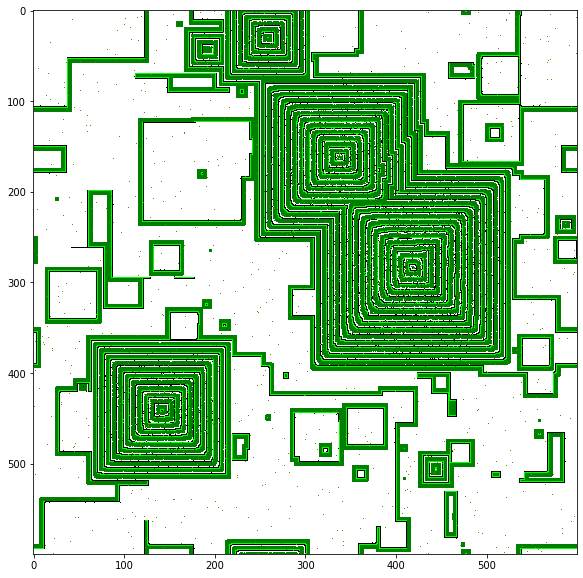

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))
im = plt.imshow(data_extract[5])

## Plotting Histograms
We use the optimized feature extraction functions in Milestone 2 to plot such histograms. We don't need to extract all the features, just the counts of "hits" to justify why our choice of cutoffs.

### Feature Extraction Functions
Listed below are the functions necessary for feature extraction.

In [74]:
import numpy as np
import cv2
from numba import jit, prange
from skimage import feature as skif
from skimage.feature import blob_log

In [90]:
# Numerically encoded cell states, after being processed by
# the master script.
CELL_N = 0  # Non activated
CELL_H = 1  # Healthy
CELL_A1 = 2  # Acute Infected
CELL_A2 = 3  # Latent Infected
CELL_D = 4  # Dead

# Dictionary to convert Precharattana model to uniform states. 0:1(healthy),
# 4:2(acute infected), 1:2(acute infected), 2:3(latent infected), 8:4(dead)
precharattana_dict = {0: 1, 4: 2, 1: 2, 2: 3, 8: 4}

# Dictionary to convert the Rana model to uniform states. 0:1(healthy),
# 2:1(healthy), 8:1(healthy), 10:1(healthy), 4:2(acute infected),
# 1:3(latent infected), 16:4(dead)
rana_dict = {0: 1, 2: 1, 8: 1, 10: 1, 4: 2, 1: 3, 16: 4}

# Self-defined color map. Used for openCV feature-extraction functions.
mycmap = {
    CELL_N: [127, 127, 127],
    CELL_H: [0, 255, 0],
    CELL_A1: [255, 0, 0],
    CELL_A2: [0, 0, 255],
    CELL_D: [0, 0, 0],
}

In [91]:
# Function that converts grids with raw values into a uniform set of values
# for all models.
@jit(nopython=True)
def im_convert(im, model):
    im_new = np.zeros((len(im), len(im[0])), dtype=np.uint8)
    if model == 'dossantos':
        for row in prange(0, len(im)):
            for col in prange(0, len(im[0])):
                value = im[row][col]
                if value == 0:
                    im_new[row][col] = 1
                elif value == 4:
                    im_new[row][col] = 2
                elif value == 1:
                    im_new[row][col] = 3
                elif value == 8:
                    im_new[row][col] = 4
    elif model == 'moonchai':
        for row in prange(0, len(im)):
            for col in prange(0, len(im[0])):
                value = im[row][col]
                if value == 0:
                    im_new[row][col] = 0
                elif value == 4:
                    im_new[row][col] = 1
                elif value == 2:
                    im_new[row][col] = 2
                elif value == 1:
                    im_new[row][col] = 3
                elif value == 8:
                    im_new[row][col] = 4
    elif model == 'precharattana':
        for row in prange(0, len(im)):
            for col in prange(0, len(im[0])):
                value = im[row][col]
                if value == 0:
                    im_new[row][col] = 1
                elif value == 4:
                    im_new[row][col] = 2
                elif value == 1:
                    im_new[row][col] = 2
                elif value == 2:
                    im_new[row][col] = 3
                elif value == 8:
                    im_new[row][col] = 4
    elif model == 'rana':
        for row in prange(0, len(im)):
            for col in prange(0, len(im[0])):
                value = im[row][col]
                if value == 0:
                    im_new[row][col] = 1
                elif value == 2:
                    im_new[row][col] = 1
                elif value == 8:
                    im_new[row][col] = 1
                elif value == 10:
                    im_new[row][col] = 1
                elif value == 4:
                    im_new[row][col] = 2
                elif value == 1:
                    im_new[row][col] = 3
                elif value == 16:
                    im_new[row][col] = 4
    elif model == 'gonzalez':
        for row in prange(0, len(im)):
            for col in prange(0, len(im[0])):
                value = im[row][col]
                if value == 0:
                    im_new[row][col] = 1
                elif value == 2:
                    im_new[row][col] = 1
                elif value == 8:
                    im_new[row][col] = 1
                elif value == 10:
                    im_new[row][col] = 1
                elif value == 4:
                    im_new[row][col] = 2
                elif value == 1:
                    im_new[row][col] = 3
                elif value == 16:
                    im_new[row][col] = 4
    return im_new

In [170]:
# Helper function that takes a grid and returns an image operable by openCV.
@jit(nopython=True)
def gridToOpenCVImage(grid):
    # Create a L by L by 3 np array
    shape = grid.shape
    res = np.zeros((shape[0], shape[1], 3), dtype=np.uint8)

    CELL_N_ARR = np.array([127, 127, 127], dtype=np.uint8)
    CELL_H_ARR = np.array([0, 255, 0], dtype=np.uint8)
    CELL_A1_ARR = np.array([255, 0, 0], dtype=np.uint8)
    CELL_A2_ARR = np.array([0, 0, 255], dtype=np.uint8)
    CELL_D_ARR = np.array([0, 0, 0], dtype=np.uint8)

    # Note that openCV stores image in BGR format. The colors
    # in mycmap are given in RGB.
    for row in prange(len(grid)):
        for col in prange(len(grid[0])):
            # Gets the color in mycmap and reverse it to BGR
            value = grid[row][col]

            if value == CELL_N:
                res[row][col] = CELL_N_ARR[::-1]
            elif value == CELL_H:
                res[row][col] = CELL_H_ARR[::-1]
            elif value == CELL_A1:
                res[row][col] = CELL_A1_ARR[::-1]
            elif value == CELL_A2:
                res[row][col] = CELL_A2_ARR[::-1]
            else:
                res[row][col] = CELL_D_ARR[::-1]
    return res


# Helper function to run the SimpleBlobDetector algorithm on a given image.
# Return all found blobs with minimum area selected by input.
# @jit
def getKeypoints(im, area):
    params = cv2.SimpleBlobDetector_Params()
    params.minThreshold = 2
    params.maxThreshold = 200
    params.filterByArea = True
    params.minArea = area
    params.filterByCircularity = False
    params.filterByConvexity = False
    params.filterByInertia = False
    detector = cv2.SimpleBlobDetector_create(params)
    return detector.detect(im)


# This function takes a grid as input and finds the number of blobs at various cutoffs
# @njit(parallel=True)
def getBlobFeatures(grid):
    counts = [None] * 20
    for cutoff in range(20):  # go up to 20
        counts[cutoff] = getKeypoints(gridToOpenCVImage(grid), cutoff)

    return counts

### Feature Extraction
We select a few frames and plot the histogram for them.

In [171]:
# These things are used the legends
import matplotlib.patches as mpatches
colors = {
    'CELL_H': [0, 255, 0],
    'CELL_A1': [255, 0, 0],
    'CELL_A2': [0, 0, 255],
    'CELL_D': [0, 0, 0],
}

names = {
    'CELL_H': 'Healthy',
    'CELL_A1': 'Acute Infected',
    'CELL_A2': 'Latent Infected',
    'CELL_D': 'Dead'
}

In [173]:
features_dict = {}

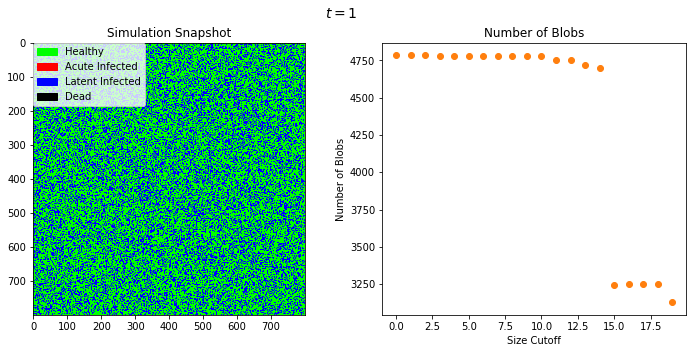

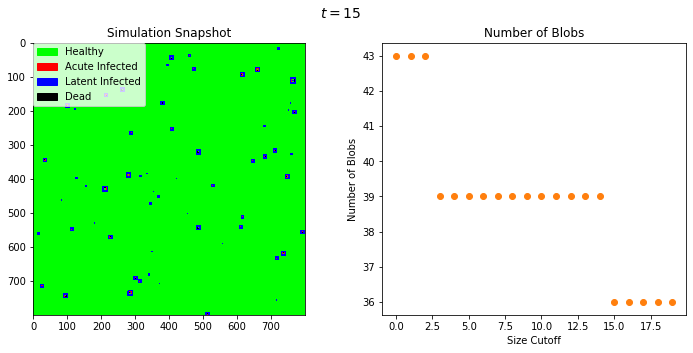

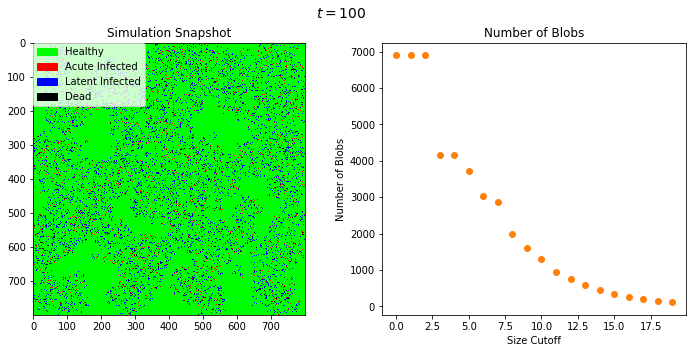

In [216]:
timesteps = [0, 15, 500]
timesteps_display = [1, 15, 100]
for time, disp_time in zip(timesteps, timesteps_display):
    data = im_convert(np.load(f'rana_data/{time}.npy'), 'rana')
    img = gridToOpenCVImage(data)
    features_dict[time] = getBlobFeatures(data)
    
    fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.scatter(range(20), list(map(lambda l : len(l), features_dict[time])), color='#ff7f0e')
    ax2.imshow(img)
    ax1.set_title('Number of Blobs')
    ax1.set_xlabel('Size Cutoff')
    ax1.set_ylabel('Number of Blobs')
    ax2.set_title('Simulation Snapshot')
    patches = [mpatches.Patch(color=np.array(colors[k]) / 255, label=names[k]) for k in colors]
    ax2.legend(handles=patches, bbox_to_anchor=(0, 1), loc=2, borderaxespad=0. )
    fig.suptitle(f'$t={disp_time}$', fontsize=14)
    plt.savefig(f'{time}.pdf')
    plt.show()

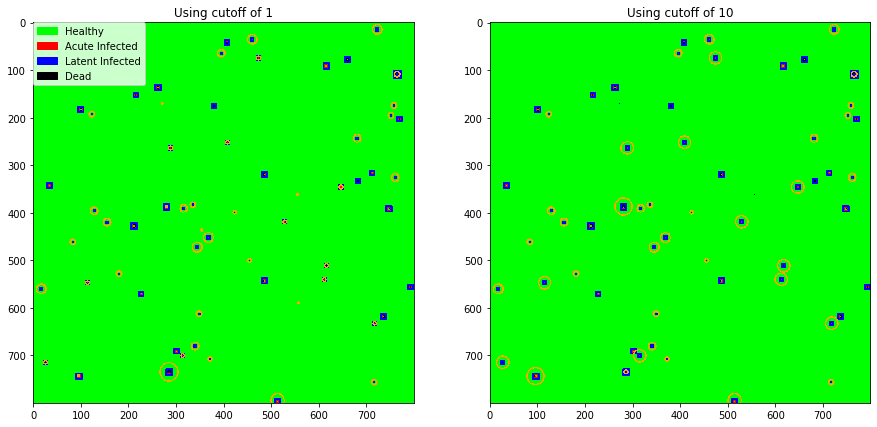

In [214]:
def drawKeyPts(im, keyp, col, th):
    for curKey in keyp:
        x = np.int(curKey.pt[0])
        y = np.int(curKey.pt[1])
        size = np.int(curKey.size)
#         size = curKey.size
        cv2.circle(im, (x, y), size, col, thickness=th, lineType=8, shift=0) 
    return im    

data = im_convert(np.load(f'rana_data/{15}.npy'), 'rana')
img = gridToOpenCVImage(data)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
ax1.imshow(drawKeyPts(img.copy(), features_dict[15][0], (255, 165, 0), 2))
ax2.imshow(drawKeyPts(img.copy(), features_dict[15][9], (255, 165, 0), 2))
patches = [mpatches.Patch(color=np.array(colors[k]) / 255, label=names[k]) for k in colors]
ax1.legend(handles=patches, bbox_to_anchor=(0, 1), loc=2, borderaxespad=0. ) 
ax1.set_title('Using cutoff of 1')
ax2.set_title('Using cutoff of 10')
plt.savefig('comparison.pdf')
plt.show()

Then perform feature extraction

In [11]:
def extract_features(numpy_array):

    import numpy as np
    import cv2

    # Helper function that converts a raw simulation result into an image operable
    # by the OpenCV library.
    def gridToOpenCVImage(grid):
        # Precharattana Model constants
        CELL_H   = 0
        CELL_A2  = 1
        CELL_A0  = 2
        CELL_A1  = 4
        CELL_D   = 8

        mycmap = {
            CELL_H: [255, 255, 255],
            CELL_A2: [0, 255, 0],
            CELL_A0: [128, 128, 0],
            CELL_A1: [0, 128, 0],
            CELL_D: [0, 0, 0], 
        }

        names = {
            CELL_H: 'Healthy',
            CELL_A2: 'Stage 1 Infected',
            CELL_A0: 'Latent Infected',
            CELL_A1: 'Stage 2 Infected', 
            CELL_D: 'Dead', 
        }
        # Create a L by L by 3 np array
        res = np.zeros([*grid.shape, 3], dtype=np.uint8)

        # trnasform grid into a format with an rgb component
        for row in range(len(grid)):
            for col in range(len(grid[0])):
                # Gets the color in mycmap and reverse it to BGR
                res[row][col] = grid[row][col][::-1]

        return res

    def getAvgDistance(keypoints):
        if keypoints == []:
            return 0

        N = len(keypoints)
        res = 0

        for kpi in keypoints:
            for kpj in keypoints:
                x1, y1 = kpi.pt
                x2, y2 = kpj.pt
                res += np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

        return res / (2 * N)

    def getAvgSize(keypoints):
        if keypoints == []:
            return 0

        return np.average([kp.size for kp in keypoints])

    # Helper function to run the SimpleBlobDetector algorithm on a given image.
    # Return all found blobs with minimum area selected by input.
    def getKeypoints(im, area):
        params = cv2.SimpleBlobDetector_Params()

        params.minThreshold = 1
        params.maxThreshold = 200

        params.filterByArea = True
        params.minArea = area

        params.filterByCircularity = False
        params.filterByConvexity = False
        params.filterByInertia = False

        detector = cv2.SimpleBlobDetector_create(params)
        return detector.detect(im)

    # Returns all the 6 features from each image. The format of return is a 1x6
    # numpy array with fields [num, dist, avg size, num, dist, avg size] where
    # the first 3 correspond to keypoints obtained when minArea = 5
    def getFeatures(im):
        keypoints_5 = getKeypoints(im, 5)
        keypoints_10 = getKeypoints(im, 10)

        return {'5_num': len(keypoints_5), '5_avg_dist': getAvgDistance(keypoints_5),
                '5_avg_size': getAvgSize(keypoints_5), '10_num': len(keypoints_10),
                '10_avg_dist': getAvgDistance(keypoints_10),
                '10_avg_dist': getAvgSize(keypoints_10)
}

    im = gridToOpenCVImage(numpy_array)
    features_dict = getFeatures(im)
    
    return features_dict


In [19]:
features = []
for i in range((np.asarray(data_extract).shape)[0]):
    features_dict = extract_features(data_extract[i])
    features.append(features_dict)

In [20]:
features_frame = pd.DataFrame(features)
features_frame.insert(0,"CELL_H", pd.Series(healthyArr), True)

features_frame.head(20)

CELL_H  5_num     5_avg_dist  5_avg_size  10_num  10_avg_dist
0   358122    171   25912.868125    5.370983     171     5.417909
1   359637     39    6158.743847    5.398345      39     5.398345
2   335590    391   44306.714477    5.857419     221     9.746760
3   312688    921  147942.640709    5.716230     395     9.780146
4   286256   2003  257966.873330    4.531580    1007     6.164460
5   226822   2915  437681.670588    4.390832    1991     5.323409
6   157582   2949  472399.618785    4.895313    2273     5.669285
7    87942   2279  346513.817780    5.353981    1691     6.157669
8    57573   1355  209089.015552    5.124193    1082     5.887653
9    51888   1154  178390.623787    5.552288     914     6.548719
10   51633   1181  184934.596151    5.325175     932     5.977397
11   50848   1249  191123.555472    5.209059     949     6.119768
12   51205   1218  189290.427746    5.252000     913     5.989197
13   51215   1225  190725.450743    5.104646     958     5.895582
14   50716   1216  188906.699181    5.007988     874     6.191044
15   50603   1167  184951.056019    5.097813     877     6.084861

Testing

In [30]:
y_col = ['CELL_H']
X_cols = [col for col in features_frame.columns if col not in y_col]

In [25]:
def nested_cv(X, y, inner_cv, outer_cv, Classifier, parameter_grid):
    outer_scores = []  # List of RMSE scores
    params_out = []  # List saving the best_params for each outer fold

    for training_samples, test_samples in outer_cv.split(X, y):
        best_params = {}
        best_score = -np.inf
        for parameters in parameter_grid:
            cv_scores = []
            for inner_train, inner_test in inner_cv.split(
                    X.loc[training_samples], y[training_samples]):
                clf = Classifier(**parameters)
                clf.fit(X.loc[inner_train], y[inner_train])
                score = clf.score(X.loc[inner_test], y[inner_test])
                cv_scores.append(score)
            mean_score = np.mean(cv_scores)
            if mean_score > best_score:
                best_score = mean_score
                best_params = parameters
        params_out.append(best_params)
        clf = Classifier(**best_params)
        clf.fit(X.loc[training_samples], y[training_samples])
#         outer_scores.append(clf.score(X.loc[test_samples], y[test_samples]))
        y_predict = clf.predict(X.loc[test_samples])
        outer_scores.append(
            np.sqrt(np.mean((y[test_samples] - y_predict) ** 2)))

    return outer_scores, params_out


In [31]:
params = ParameterGrid({
        'max_depth': [4, 8, 16, 32, 64],
        'min_samples_split': [2, 4, 8, 16, 32]
    })
scores, param = nested_cv(features_frame[X_cols], features_frame[y_col], KFold(n_splits=10), KFold(n_splits=10),
                          DecisionTreeRegressor, params)
row = [model, y_col, 5]
row.extend([scores[i] for i in range(10)])
row.extend([np.average(scores), np.std(scores)])
row.extend([param[i][k] for i in range(10) for k in ['max_depth', 'min_samples_split']])

KeyError: "None of [Int64Index([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], dtype='int64')] are in the [columns]"